In [141]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

In [142]:
# First, lets load the dataset
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
    transforms.RandomAdjustSharpness(3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])
])
data_train = dset.SVHN('./data/',
                       transform=tfs
                      )
data_test = dset.SVHN('./data/', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ]))

In [143]:
batch_size = 64
want_size = 1000

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * want_size))
indices = list(range(data_size))
np.random.shuffle(indices)
indices = indices[:want_size]

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [144]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [145]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        scheduler.step()
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        print("epoch %d Average loss: %f, Train accuracy: %f, val accuracy: %f" %
                  (epoch+1, ave_loss, train_accuracy, val_accuracy))
        #if train_accuracy < 0.15:
        #    return loss_history, train_history, val_history

    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        # x_gpu = x.to(device)
        # y_gpu = y.to(device)
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]

    train_accuracy = float(correct_samples) / total_samples
    return train_accuracy

#loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

In [146]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'gamma', 'step_size', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

run_record = {}
epoch_num = 20
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
for i in range(10):

    my_model = nn.Sequential(
      nn.Conv2d(3, 6, 5, padding=0),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(6),
      nn.MaxPool2d(2),
      nn.Conv2d(6, 16, 5, padding=0),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(2),
      Flattener(),
      nn.Linear(16*5*5, 120),
      nn.ReLU(inplace=True),
      nn.BatchNorm1d(120),
      nn.Linear(120, 84),
      nn.ReLU(inplace=True),
      nn.BatchNorm1d(84),
      nn.Linear(84, 10)
      )

    #lr = 10**np.random.uniform(-5, -1)
    lr = 0.0061
    reg = 3.4e-5
    gamma = 0.5
    step_size = 4
    print(f"exp {i}", "learning_rate =", lr, "(learning_rate_decay, step_size) =", f"({gamma},{step_size})", "reg =", reg, "batch_size =", batch_size)


    optimizer = optim.Adam(my_model.parameters(), lr=lr, weight_decay=reg)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    loss_history, train_history, val_history = train_model(my_model, train_loader, val_loader, loss, optimizer, scheduler, epoch_num)
    hp = Hyperparams(learning_rate=lr, gamma=gamma, reg=reg, step_size=step_size)
    rr = RunResult(model = my_model, train_history = train_history, val_history=val_history, final_val_accuracy=val_history[-1])
    run_record[hp] = rr

exp 0 learning_rate = 0.0061 (learning_rate_decay, step_size) = (0.4,4) reg = 3.4e-05 batch_size = 64
epoch 1 Average loss: 2.434959, Train accuracy: 0.211250, val accuracy: 0.200000
epoch 2 Average loss: 2.021086, Train accuracy: 0.361250, val accuracy: 0.260000
epoch 3 Average loss: 1.658235, Train accuracy: 0.472500, val accuracy: 0.420000
epoch 4 Average loss: 1.246600, Train accuracy: 0.621250, val accuracy: 0.545000
epoch 5 Average loss: 1.037915, Train accuracy: 0.703750, val accuracy: 0.565000
epoch 6 Average loss: 0.831492, Train accuracy: 0.772500, val accuracy: 0.590000
epoch 7 Average loss: 0.667197, Train accuracy: 0.827500, val accuracy: 0.620000
epoch 8 Average loss: 0.504001, Train accuracy: 0.890000, val accuracy: 0.610000
epoch 9 Average loss: 0.433561, Train accuracy: 0.923750, val accuracy: 0.600000
epoch 10 Average loss: 0.380609, Train accuracy: 0.928750, val accuracy: 0.620000
epoch 11 Average loss: 0.349347, Train accuracy: 0.932500, val accuracy: 0.640000
epoch

In [147]:
result = sorted(list(run_record.items()),key=lambda x:x[1].final_val_accuracy)[::-1]

In [148]:
for a,b in result:
    print(a, b.final_val_accuracy)

Hyperparams(learning_rate=0.0061, gamma=0.4, step_size=4, reg=3.4e-05) 0.595


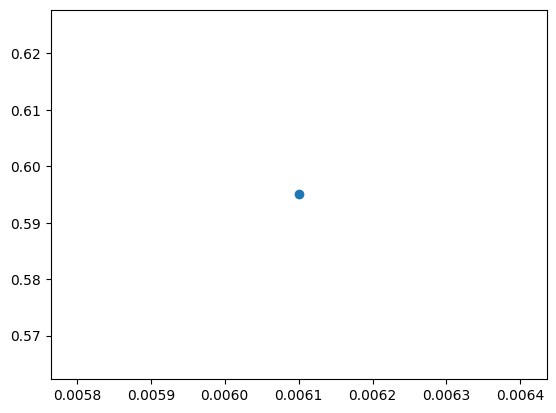

In [149]:
plt.scatter([a.learning_rate for a,b in result], [b.final_val_accuracy for a,b in result])

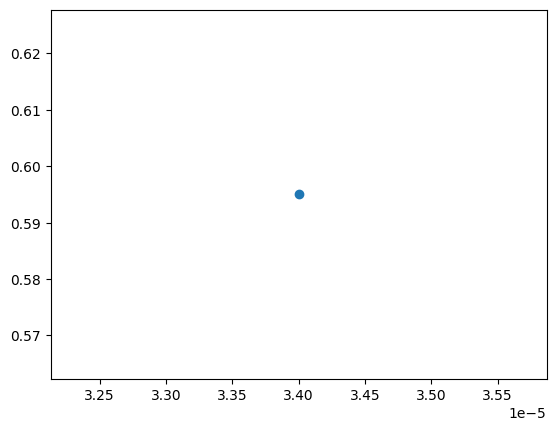

In [150]:
plt.scatter([a.reg for a,b in result], [b.final_val_accuracy for a,b in result])

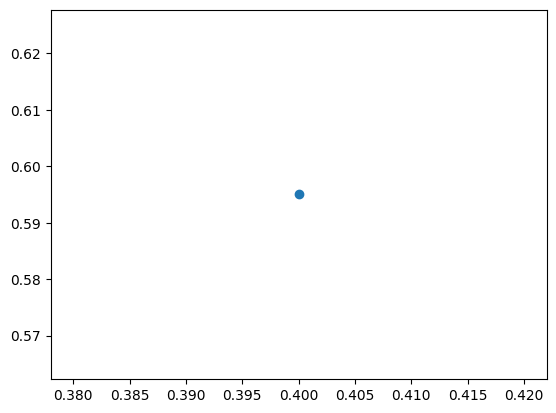

In [151]:
plt.scatter([a.gamma for a,b in result], [b.final_val_accuracy for a,b in result])

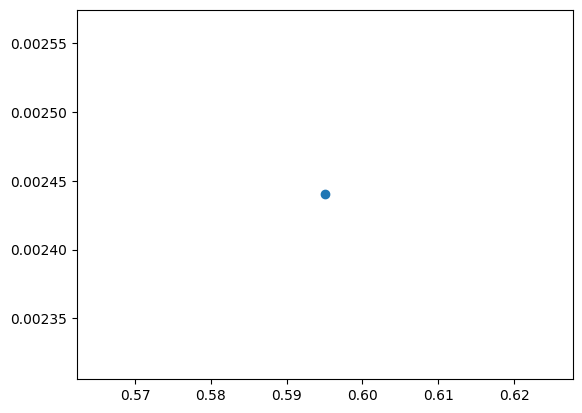

In [152]:
plt.scatter([b.final_val_accuracy for a,b in result], [a.learning_rate*a.gamma for a,b in result])

In [153]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(my_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.6064
